# Anwendungsfall: Segmentierung von Kunden einer Shopping Mall

### Problemstellung
Sie sind Inhaber eines Einkaufszentrums und sammeln anhand eines Kundenprogramms Informationen über Einkäufe, Alter, Geschlecht und Kaufkraft der Besucher.

### Zielformulierung
Ziel dieses Projektes ist es, die Kunden besser zu verstehen und zu segmentieren. Dadurch erhoffen Sie sich eine gezieltere Ansprache und Nutzung von Werbekanälen.

### Offene Fragen
1.   Wie ist das Verhältnis von männlichen zu weiblichen Kunden?
2.   Unterscheiden sich die Kaufkraft und das Kaufverhalten?
3.   Existieren unterschiedliche Verhaltensweisen je nach Lebensalter?
4.   Wie können Kunden möglichst gut segmentiert werden?
5.   Ist es durch PCA oder Normalisierung der Daten möglich, die Segmentierung zu optimieren?



## Übersicht

Dieses Notebook bietet ein Überblick über die Möglichkeiten der Kundensegmentierung mittels KMeans.

### 1.   Import der Bibliotheken
### 2.   Laden der Daten
### 3.   Explorative Datenanalyse (EDA)
### 4.   KMeans Implementierung und Optimierung
### 5.   Fazit



### 1 Import der Bibliotheken

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA # Principial Component Analysis
from sklearn.cluster import KMeans # K-Means Clustering
from sklearn.metrics import silhouette_samples, silhouette_score # Silhouette

%matplotlib inline

### 2 Laden der Daten

In [0]:
def read_csv(source):
  '''Read data from source'''
  return pd.read_csv(source)

In [0]:
source = read_csv("https://mall-customers.s3-eu-west-1.amazonaws.com/Mall_Customers.csv")

In [0]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Genre                     200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 2.1 Optimierungen und Transformationen

In [0]:
# Rename columns for easier use and correct misspelling
source.rename(columns={'Genre':'Gender',
                   'Annual Income (k$)':'Annual_Income',
                   'Spending Score (1-100)':'Spending_Score'
                  }, 
                   inplace=True
          )

In [0]:
# Remove irrelevant Customer ID
df = source[['Gender','Age','Annual_Income','Spending_Score']]

In [0]:
# Show adjusted dataframe 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender            200 non-null object
Age               200 non-null int64
Annual_Income     200 non-null int64
Spending_Score    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ KB


### 2.2 Überprüfung auf fehlerhafte Einträge

In [0]:
def show_missing_values(dataframe):
  '''Show missing values in columns'''
  return dataframe.isnull().sum()

In [0]:
show_missing_values(df)

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

### 3 Explorative Datenanalyse (EDA)

### 3.1 Univariate Analyse

In [0]:
# Describe columns
df.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [0]:
# Show Male / Female distribution
def show_count_plot(dataframe,column):
  '''Show Count Plot. Requires column name as string'''
  plt.figure(1 , figsize = (15 , 5))
  sns.countplot(y = column , data = df)
  return plt.show()

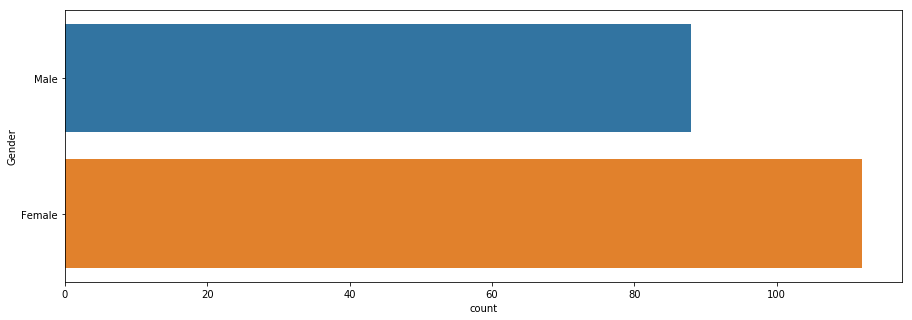

In [0]:
show_count_plot(df,'Gender')

Der Datensatz beinhaltet mehr Frauen als Männer.

In [0]:
# Distribution plot
def show_distribution_plot(dataframe,list):
  plt.figure(1 , figsize = (15 , 6))
  n = 0 
  for x in list:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(dataframe[x] , bins = 20)
    plt.title('Distribution plot of {}'.format(x))
  return plt.show()

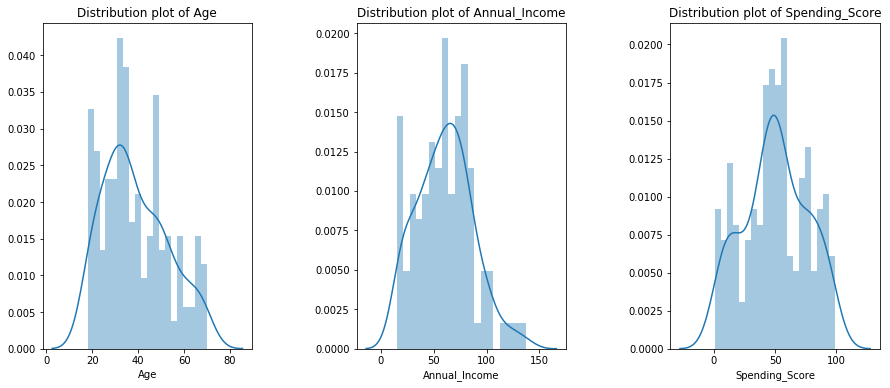

In [0]:
show_distribution_plot(df,['Age', 'Annual_Income', 'Spending_Score'])

Der Median des Alters liegt bei ca. 39 Jahren. Das Medianeinkommen beträgt etwa 60.000 US-Dollar pro Jahr.

### 3.2 Multivariate Analyse

In [0]:
# Swarm Plot
def show_swarm_plot(dataframe,list):
  plt.figure(1 , figsize = (15 , 7))
  n = 0 
  for cols in list:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = dataframe , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = dataframe)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Age, Annual Income and Spending Score for Male and Female' if n == 2 else '')
  return plt.show()

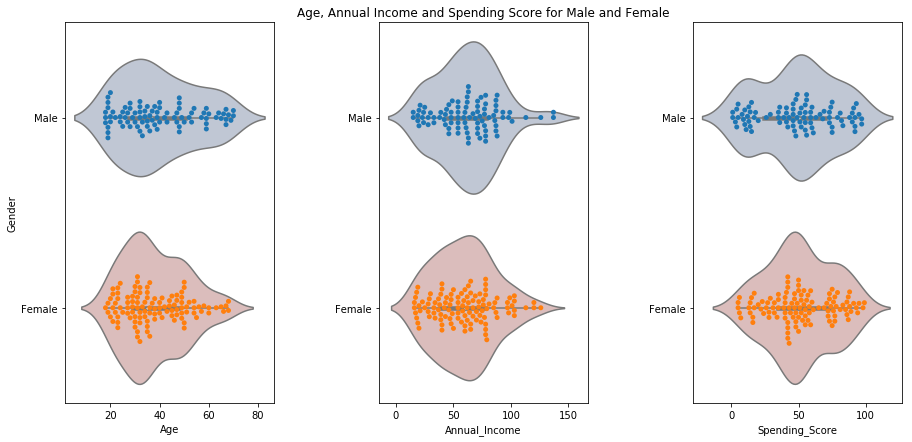

In [0]:
# Show distribution of Age, Annual Income and Spending Score differenced for Male and Female
show_swarm_plot(df,['Age' , 'Annual_Income' , 'Spending_Score'])

### 4 KMeans

### 4.1 Erforderliche Transformationen

In [0]:
# Encode gender for KMeans: String to 1/0
def encode(dataframe,column_name):
  '''Encodes column'''
  encode = LabelEncoder()
  encoded_array = encode.fit_transform(dataframe[column_name])
  return encoded_array

In [0]:
# Decode gender
def decode(dataframe,column_name):
  encode = LabelEncoder()
  encoded_array = encode.fit_transform(dataframe[column_name])
  decoded_array = encode.inverse_transform(encoded_array)
  return decoded_array

In [0]:
# Append 'Gender_Transformation' to Dataframe
df['Gender_Transformation']= encode(df,'Gender')

In [0]:
# Remove original column 'Gender'
df = df[['Age','Annual_Income','Spending_Score','Gender_Transformation']]

In [0]:
# Show first five rows of new dataframe
df.head(5)

,Age,Annual_Income,Spending_Score,Gender_Transformation
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


### 4.2 Ermittlung der Anzahl an Clustern

### 4.2.1 Ellbogen Methode

In [0]:
# Further information: https://bl.ocks.org/rpgove/0060ff3b656618e9136b
def show_elbow_method(dataframe):
  '''Simple elbow method implementation'''
  distortions = []
  range_n_clusters = range(1, 10)
  for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 23)
    km.fit(dataframe)
    distortions.append(km.inertia_)
  plt.plot(range_n_clusters, distortions)
  plt.title("Elbow Method")
  plt.xlabel("Number of Clusters")
  plt.ylabel("Sum Squared Error (SSE)")
  return plt.show()

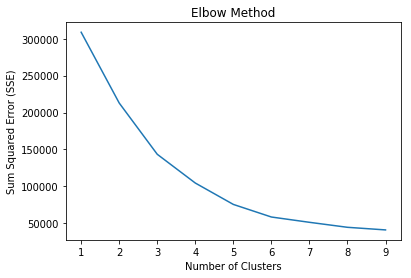

In [0]:
show_elbow_method(df)

### 4.2.2 Silhouette Analyse

In [0]:
# Documentation: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
def show_silhouette(dataframe):
  '''Show silhouette for 2 to 10 clusters'''
  range_n_clusters = range(2,11)
  for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataframe)
    centers = clusterer.cluster_centers_

    score = silhouette_score (dataframe, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

In [0]:
# Show Silhouette Score for original dataframe
show_silhouette(df)

For n_clusters = 2, silhouette score is 0.29307334005502633)
For n_clusters = 3, silhouette score is 0.383798873822341)
For n_clusters = 4, silhouette score is 0.4052954330641215)
For n_clusters = 5, silhouette score is 0.4440669204743008)
For n_clusters = 6, silhouette score is 0.45206493204632353)
For n_clusters = 7, silhouette score is 0.4409411333609709)
For n_clusters = 8, silhouette score is 0.425945425758392)
For n_clusters = 9, silhouette score is 0.4156856055749279)
For n_clusters = 10, silhouette score is 0.379405876353367)


Verbesserte eine Reduzierung der Dimensionen die Silhouette der Cluster?

In [0]:
show_silhouette(df[['Annual_Income','Spending_Score']])

For n_clusters = 2, silhouette score is 0.2968969162503008)
For n_clusters = 3, silhouette score is 0.46761358158775435)
For n_clusters = 4, silhouette score is 0.4931963109249047)
For n_clusters = 5, silhouette score is 0.553931997444648)
For n_clusters = 6, silhouette score is 0.5379675585622219)
For n_clusters = 7, silhouette score is 0.5288104473798049)
For n_clusters = 8, silhouette score is 0.4583576977507227)
For n_clusters = 9, silhouette score is 0.4537497748056438)
For n_clusters = 10, silhouette score is 0.4416208208785718)


### 4.3 Visualisierung

In [0]:
def show_kmeans_clustering(data,n_clusters,xlabel,ylabel):
  '''K-Means Clustering. Number of clusters required'''
  km = KMeans(n_clusters=n_clusters)
  cluster = km.fit(data)
  plt.scatter(data[:, 0], data[:, 1], label='Customer')
  plt.scatter(cluster.cluster_centers_[:, 0], cluster.cluster_centers_[:, 1], label='Centroids')
  plt.title('KMeans: {} Cluster'.format(n_clusters))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  return plt.show()
                  

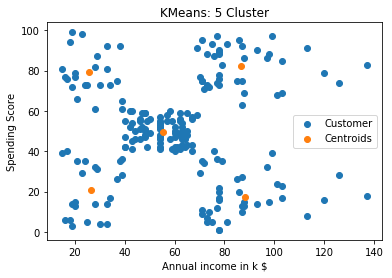

In [0]:
# Five clusters achieve the highest silhouette score
show_kmeans_clustering(df[['Annual_Income','Spending_Score']].values,5,'Annual income in k $', 'Spending Score')

Können wir das Alter und Geschlecht mit einbeziehen und die Cluster Silhouette dennoch mittels PCA verbessern?

### 4.4 Optimierung

### 4.4.1 Principal Component Analysis (PCA)

Wenn wir die Cluster visualisieren wollen, geschieht dies als Diagramm meist zwei- oder dreidimensional. In diesem Abschnitt wird der Datensatz mittels PCA auf zwei Dimensionen reduziert. 

In [0]:
def reduce_dimensions(dataframe,n_components):
  '''Reduce dimensions for visualization. Requires number of dimensions as Parameter'''
  pca_reducer = PCA(n_components=n_components)
  return pca_reducer.fit_transform(dataframe)

In [0]:
reduced_df_2d = reduce_dimensions(df,2)

In [0]:
# Show Silhouette Score after PCA
show_silhouette(reduced_df_2d)

For n_clusters = 2, silhouette score is 0.3424931686350321)
For n_clusters = 3, silhouette score is 0.4510533084363185)
For n_clusters = 4, silhouette score is 0.49666554997066514)
For n_clusters = 5, silhouette score is 0.5526264331833406)
For n_clusters = 6, silhouette score is 0.5344483744329872)
For n_clusters = 7, silhouette score is 0.5212199458305052)
For n_clusters = 8, silhouette score is 0.4468858820617471)
For n_clusters = 9, silhouette score is 0.4532204110299475)
For n_clusters = 10, silhouette score is 0.4526054115657853)


Der Silhouette Wert für fünf Cluster wird minimal verbessert!

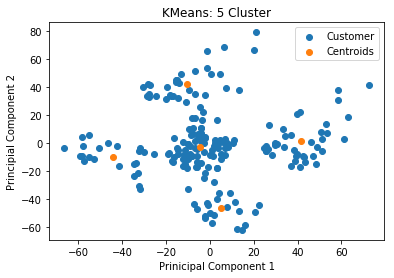

In [0]:
show_kmeans_clustering(reduced_df_2d,5, 'Prinicipal Component 1','Principial Component 2')

Können wir das Ergebnis noch durch verschiedene Normalisierungen noch verbessern?







### 4.4.2 Normalisierung

### 4.4.2.1 StandardScaler

In [0]:
# More information: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html
def standard_scaler(dataframe):
  '''Apply Standard Scaler on dataset'''
  data = StandardScaler().fit_transform(dataframe)
  df = pd.DataFrame({'Age': data[:, 0], 'Annual_Income': data[:, 1], 'Spending_Score': data[:, 2], 'Gender_Transformation': data[:, 3]})
  return df

In [0]:
df_standard_scaled = standard_scaler(df)
df_standard_scaled.head(5)

,Age,Annual_Income,Spending_Score,Gender_Transformation
0,-1.424569,-1.738999,-0.434801,1.128152
1,-1.281035,-1.738999,1.195704,1.128152
2,-1.352802,-1.700830,-1.715913,-0.886405
3,-1.137502,-1.700830,1.040418,-0.886405
4,-0.563369,-1.662660,-0.395980,-0.886405


In [0]:
show_silhouette(df_standard_scaled[['Annual_Income','Spending_Score']])

For n_clusters = 2, silhouette score is 0.28953270137686243)
For n_clusters = 3, silhouette score is 0.46658474419000145)
For n_clusters = 4, silhouette score is 0.4939069237513199)
For n_clusters = 5, silhouette score is 0.5546571631111091)
For n_clusters = 6, silhouette score is 0.5398800926790663)
For n_clusters = 7, silhouette score is 0.5281492781108291)
For n_clusters = 8, silhouette score is 0.45330041196473286)
For n_clusters = 9, silhouette score is 0.4566624374485964)
For n_clusters = 10, silhouette score is 0.4455980500899635)


Die Silhouette wird durch die Standardskalierung bei fünf Clustern weiterhin verbessert!

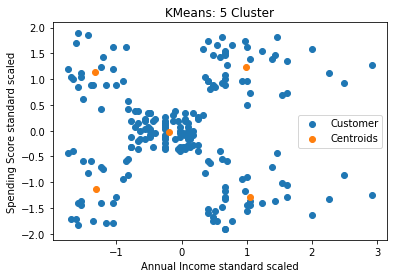

In [0]:
show_kmeans_clustering(df_standard_scaled[['Annual_Income','Spending_Score']].values,5,'Annual Income standard scaled', 'Spending Score standard scaled')

### 4.4.2.2 MinMaxScaler

In [0]:
def minmax_scaler(dataframe):
  '''Apply MinMax Scaler on dataset'''
  data = MinMaxScaler().fit_transform(dataframe)
  df = pd.DataFrame({'Age': data[:, 0], 'Annual_Income': data[:, 1], 'Spending_Score': data[:, 2], 'Gender_Transformation': data[:, 3]})
  return df

In [0]:
df_minmax_scaled = minmax_scaler(df)
df_minmax_scaled.head(5)

,Age,Annual_Income,Spending_Score,Gender_Transformation
0,0.019231,0.000000,0.387755,1.0
1,0.057692,0.000000,0.816327,1.0
2,0.038462,0.008197,0.051020,0.0
3,0.096154,0.008197,0.775510,0.0
4,0.250000,0.016393,0.397959,0.0


In [0]:
show_silhouette(df_minmax_scaled[['Annual_Income','Spending_Score']])

For n_clusters = 2, silhouette score is 0.33340205479521)
For n_clusters = 3, silhouette score is 0.4514909309424474)
For n_clusters = 4, silhouette score is 0.49620078745146784)
For n_clusters = 5, silhouette score is 0.5594854531227246)
For n_clusters = 6, silhouette score is 0.535817696916733)
For n_clusters = 7, silhouette score is 0.5185859609857723)
For n_clusters = 8, silhouette score is 0.4322805234768182)
For n_clusters = 9, silhouette score is 0.44188172065332326)
For n_clusters = 10, silhouette score is 0.439283997350404)


Die MinMax-Skalierung verbessert den Score bei fünf Clustern! Zu beachten ist, dass der MinMax Scaler sehr anfällig bei Ausreißern ist.

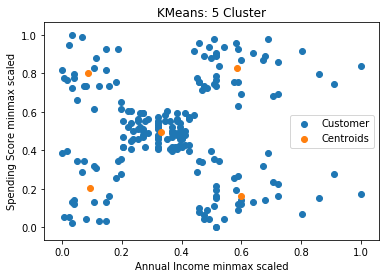

In [0]:
show_kmeans_clustering(df_minmax_scaled[['Annual_Income','Spending_Score']].values,5,'Annual Income minmax scaled', 'Spending Score minmax scaled')

### 4.4.2.3 RobustScaler

In [0]:
def robust_scaler(dataframe):
  '''Apply Robust Scaler on dataset'''
  data = RobustScaler().fit_transform(dataframe)
  df = pd.DataFrame({'Age': data[:, 0], 'Annual_Income': data[:, 1], 'Spending_Score': data[:, 2], 'Gender_Transformation': data[:, 3]})
  return df

In [0]:
df_robust_scaled = robust_scaler(df)
df_robust_scaled.head(5)

,Age,Annual_Income,Spending_Score,Gender_Transformation
0,-0.839506,-1.273973,-0.287582,1.0
1,-0.740741,-1.273973,0.810458,1.0
2,-0.790123,-1.246575,-1.150327,0.0
3,-0.641975,-1.246575,0.705882,0.0
4,-0.246914,-1.219178,-0.261438,0.0


In [0]:
show_silhouette(df_robust_scaled[['Annual_Income','Spending_Score']])

For n_clusters = 2, silhouette score is 0.3967530428722762)
For n_clusters = 3, silhouette score is 0.47029393594847796)
For n_clusters = 4, silhouette score is 0.4909840957730004)
For n_clusters = 5, silhouette score is 0.5516518249155914)
For n_clusters = 6, silhouette score is 0.5390883548184416)
For n_clusters = 7, silhouette score is 0.5284566885380275)
For n_clusters = 8, silhouette score is 0.4623527108853179)
For n_clusters = 9, silhouette score is 0.43692468023265013)
For n_clusters = 10, silhouette score is 0.4504277733366838)


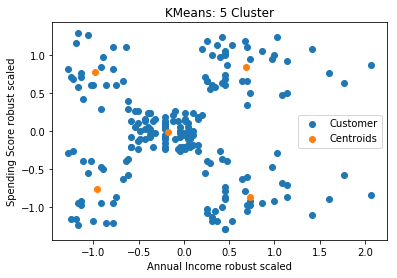

In [0]:
show_kmeans_clustering(df_robust_scaled[['Annual_Income','Spending_Score']].values,5,'Annual Income robust scaled', 'Spending Score robust scaled')

Eine Normalisierung mittels RobustScaler() minimiert die Silhouette für fünf Cluster.

# 5 Fazit

## 5.1 Clustering

Für das Clustering der Kunden empfiehlt sich der Zusammenhang zwischen dem jährlichen Einkommen und der internen Bewertung mittels des Spending Scores. Insgesamt können die Konsumenten in fünf Cluster eingeordnet werden:


1.   Niedriges Einkommen und niedriger Spending Score
2.   Niedriges Einkommen und hoher Spending Score
3.   Mittleres Einkomen und mittlerer Spending Score
4.   Hohes Einkommen und niedriger Spending Score
5.   Hohes Einkommen und hoher Spending Score

Das Geschlecht und Alter hat für das Clustering minimale Implikationen. Betrachten wir aber beispielsweise je nach Geschlecht die Altersverteilung, werden Unterschiede deutlich: Es existieren mehr Kundendaten bei Frauen im Alter von dreißig Jahren als bei Männern. Auch die Verteilung des Einkommens und der Spending Score verhält sich je nach Geschlecht unterschiedlich (siehe 3.2).





## 5.2 Optimierung
Die Principal Component Analyse erbringt minimale Verbesserungen. Dies deckt sich mit den Erfahrungen aus 5.1, dass Alter und Geschlecht wenig Einfluss auf das Clustering hat. Darüber hinaus ist die Auswahl verschiedener Normalisierungstechniken von Vorteil (4.4.2)

## 5.3 Geschäftsimplikationen

Mit den Erfahrungen aus der multivariaten Analyse (3.2) und dem Clustering (4) ist es möglich, Kunden zu klassifizieren und zielgerichetet anzusprechen. Weiterhin ist es möglich potenzielle Kunden einzuschätzen und das Marketing auf vielversprechendes Klientel hin auszurichten. Somit wird nicht nur die Beziehung zu Bestandskunden intensiviert, sondern auch Neukundenakquise intelligent betrieben.